In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
# import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../"))

from distance_functions import *
import scipy.stats

# Load distances and representations

In [2]:
folder = "distances/train/pretrained"

In [3]:
# Load the ImageNet distances between train datasets
filenames = os.listdir(folder)
distnames = []
for filename in filenames:
    if filename.endswith("npy"):
        distnames.append(filename[:-4])
distnames = np.sort(distnames)

In [4]:
print(distnames)

['lin_cka_dist' 'lin_cka_prime_dist' 'mean_cca_e2e' 'mean_sq_cca_e2e'
 'predictor_dist_0.0' 'predictor_dist_0.0001' 'predictor_dist_0.001'
 'predictor_dist_0.01' 'predictor_dist_0.1' 'predictor_dist_1.0'
 'predictor_dist_10.0' 'predictor_dist_100.0' 'predictor_dist_1000.0'
 'predictor_dist_10000.0' 'predictor_dist_1e-05' 'predictor_dist_1e-06'
 'predictor_dist_1e-07' 'predictor_dist_1e-08' 'predictor_dist_1e-09'
 'predictor_dist_1e-10' 'predictor_dist_1e-11' 'predictor_dist_1e-12'
 'predictor_dist_1e-13' 'predictor_dist_1e-14' 'predictor_dist_1e-15'
 'predictor_dist_1e-16' 'predictor_dist_1e-17' 'predictor_dist_1e-18'
 'predictor_dist_1e-19' 'predictor_dist_1e-20' 'procrustes'
 'pwcca_dist_e2e']


In [5]:
stats = np.load(f"{folder}/stats.npz")
model_names = stats["model_names"]
total_models = len(model_names)
dist_pairs_saved = stats["dist_pairs_saved"]

In [6]:
# Check all distance pairs are saved. The output should be all-zeros
print(np.arange(total_models) - np.sum(dist_pairs_saved, axis=0))
print(np.arange(total_models) - np.flip(np.sum(dist_pairs_saved, axis=1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
print(model_names)

['alexnet_pretrained_rep' 'convnext_base_pretrained_rep'
 'convnext_large_pretrained_rep' 'convnext_small_pretrained_rep'
 'convnext_tiny_pretrained_rep' 'efficientnet_b0_pretrained_rep'
 'efficientnet_b1_pretrained_rep' 'efficientnet_b2_pretrained_rep'
 'efficientnet_b3_pretrained_rep' 'efficientnet_b4_pretrained_rep'
 'efficientnet_b5_pretrained_rep' 'efficientnet_b6_pretrained_rep'
 'efficientnet_b7_pretrained_rep' 'googlenet_pretrained_rep'
 'inception_pretrained_rep' 'mnasnet_pretrained_rep'
 'mobilenet_v2_pretrained_rep' 'mobilenet_v3_large_pretrained_rep'
 'mobilenet_v3_small_pretrained_rep' 'regnet_x_16gf_pretrained_rep'
 'regnet_x_1_6gf_pretrained_rep' 'regnet_x_32gf_pretrained_rep'
 'regnet_x_3_2gf_pretrained_rep' 'regnet_x_400mf_pretrained_rep'
 'regnet_x_800mf_pretrained_rep' 'regnet_x_8gf_pretrained_rep'
 'regnet_y_16gf_pretrained_rep' 'regnet_y_1_6gf_pretrained_rep'
 'regnet_y_32gf_pretrained_rep' 'regnet_y_3_2gf_pretrained_rep'
 'regnet_y_400mf_pretrained_rep' 'regnet_y_

In [8]:
distances = {}
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B
for distname in distnames:
    print(distname)
    curr_dist = np.load(f"{folder}/{distname}.npy")  
    distances[distname] = symmetrize(curr_dist)
#     print(distances[distname])

lin_cka_dist
lin_cka_prime_dist
mean_cca_e2e
mean_sq_cca_e2e
predictor_dist_0.0
predictor_dist_0.0001
predictor_dist_0.001
predictor_dist_0.01
predictor_dist_0.1
predictor_dist_1.0
predictor_dist_10.0
predictor_dist_100.0
predictor_dist_1000.0
predictor_dist_10000.0
predictor_dist_1e-05
predictor_dist_1e-06
predictor_dist_1e-07
predictor_dist_1e-08
predictor_dist_1e-09
predictor_dist_1e-10
predictor_dist_1e-11
predictor_dist_1e-12
predictor_dist_1e-13
predictor_dist_1e-14
predictor_dist_1e-15
predictor_dist_1e-16
predictor_dist_1e-17
predictor_dist_1e-18
predictor_dist_1e-19
predictor_dist_1e-20
procrustes
pwcca_dist_e2e


In [9]:
rep_folder_prefix = '../../imagenet_experiments/'
train_reps_folder = rep_folder_prefix + 'reps/train/10000_eval/'
val_reps_folder = rep_folder_prefix + 'reps/val/3000_eval/'

# Load ImageNet representations
reps_train = {} # Train dataset
reps_val = {} # Validation dataset
try:
    for model_name in model_names:
        print(model_name)
        rep1 = np.load(train_reps_folder + model_name + ".npy")
        # center and normalize
        rep1 = rep1 - rep1.mean(axis=1, keepdims=True)
        rep1 = rep1 / np.linalg.norm(rep1)
        rep1 = rep1 * np.sqrt(rep1.shape[1])
        reps_train[model_name] = rep1

        rep2 = np.load(val_reps_folder + model_name + ".npy")
        # center and normalize
        rep2 = rep2 - rep2.mean(axis=1, keepdims=True)
        rep2 = rep2 / np.linalg.norm(rep2)
        rep2 = rep2 * np.sqrt(rep2.shape[1])
        reps_val[model_name] = rep2
        

except FileNotFoundError as e:
    print('WARNING: IN ORDER TO RUN THIS CODE, THE IMAGENET REPRESENTATIONS MUST COMPUTED. SEE README.')
    raise e

alexnet_pretrained_rep
convnext_base_pretrained_rep
convnext_large_pretrained_rep
convnext_small_pretrained_rep
convnext_tiny_pretrained_rep
efficientnet_b0_pretrained_rep
efficientnet_b1_pretrained_rep
efficientnet_b2_pretrained_rep
efficientnet_b3_pretrained_rep
efficientnet_b4_pretrained_rep
efficientnet_b5_pretrained_rep
efficientnet_b6_pretrained_rep
efficientnet_b7_pretrained_rep
googlenet_pretrained_rep
inception_pretrained_rep
mnasnet_pretrained_rep
mobilenet_v2_pretrained_rep
mobilenet_v3_large_pretrained_rep
mobilenet_v3_small_pretrained_rep
regnet_x_16gf_pretrained_rep
regnet_x_1_6gf_pretrained_rep
regnet_x_32gf_pretrained_rep
regnet_x_3_2gf_pretrained_rep
regnet_x_400mf_pretrained_rep
regnet_x_800mf_pretrained_rep
regnet_x_8gf_pretrained_rep
regnet_y_16gf_pretrained_rep
regnet_y_1_6gf_pretrained_rep
regnet_y_32gf_pretrained_rep
regnet_y_3_2gf_pretrained_rep
regnet_y_400mf_pretrained_rep
regnet_y_800mf_pretrained_rep
regnet_y_8gf_pretrained_rep
resnet18_pretrained_rep
resnex

# Predict generalization, random y's

In [10]:
def find_best_pred(y, lmbda, reps):
    # ridge regression 
    # assume reps is dimension x number datapoints 
    rep_dim = reps.shape[0]
    numpts = reps.shape[1]
    
    return np.linalg.solve((lmbda*np.eye(rep_dim) + (reps @ reps.T) / numpts), reps@y)
    

In [11]:
def get_collected_correlations(lmbda, numtrials=50, numtrainsamples=10000):
    collected_correlations = []

    labels = []
    for ky,val in distances.items():
        if ky != 'predictor_dist_range':
            labels.append(ky)
#     print(labels)

    def flatten_upper_right_triangle(curr_mat):
        cv = []
        assert(curr_mat.shape[0] == curr_mat.shape[1])
        assert(curr_mat.shape[0] == len(model_names))
        for i in range(len(model_names)-1):
            for j in range(i+1,len(model_names)):
                cv.append(curr_mat[i,j])
        cv = np.asarray(cv)
        return cv

    dist_vecs = {}

    for distname in labels:
        dist_vecs[distname] = flatten_upper_right_triangle(distances[distname])

    for tri in range(numtrials):
        print(f'Trial {tri}')

        y = np.random.randn(numtrainsamples,1) + 1

        preds = {}
        for model_name in model_names:
    #         print(model_name)
            preds[model_name] = find_best_pred(y, lmbda, reps_train[model_name][:,0:numtrainsamples])

    #     # For each pair, compute the squared distance between predictions, averaged over test instances 

        errs = np.zeros((len(model_names), len(model_names)))
        for ind1 in range(0, len(model_names)-1):
            for ind2 in range(ind1+1, len(model_names)):
                cp1 = preds[model_names[ind1]].T @ reps_val[model_names[ind1]]
                cp2 = preds[model_names[ind2]].T @ reps_val[model_names[ind2]]
    #             print(cp1.shape)
                errs[ind1, ind2] = np.linalg.norm(cp1 - cp2)
                errs[ind2, ind1] = errs[ind1, ind2]
        err_vec = flatten_upper_right_triangle(errs)

        correlations = []

        for distname in labels:
            val = scipy.stats.spearmanr(err_vec, dist_vecs[distname]).correlation
            correlations.append(val)

        collected_correlations.append(correlations)
        
    return labels, collected_correlations

In [12]:
reps_train['alexnet_pretrained_rep'].shape

(4096, 10000)

In [13]:
label_names_dict = {'lin_cka_dist': 'CKA', 'mean_sq_cca_e2e' : 'CCA', 'pwcca_dist_e2e': 'PWCCA', 'procrustes': 'Procrustes'}

label_names_dict['predictor_dist_0.0'] = 'GULP, $\lambda = 0$'
label_names_dict['predictor_dist_1e-07'] = 'GULP, $\lambda = 10^{-7}$'
label_names_dict['predictor_dist_1e-06'] = 'GULP, $\lambda = 10^{-6}$'
label_names_dict['predictor_dist_1e-05'] = 'GULP, $\lambda = 10^{-5}$'
label_names_dict['predictor_dist_0.0001'] = 'GULP, $\lambda = 10^{-4}$'
label_names_dict['predictor_dist_0.001'] = 'GULP, $\lambda = 10^{-3}$'
label_names_dict['predictor_dist_0.01'] = 'GULP, $\lambda = 10^{-2}$'
label_names_dict['predictor_dist_0.1'] = 'GULP, $\lambda = 10^{-1}$'
label_names_dict['predictor_dist_1.0'] = 'GULP, $\lambda = 1$'
label_names_dict['predictor_dist_10.0'] = 'GULP, $\lambda = 10$'

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


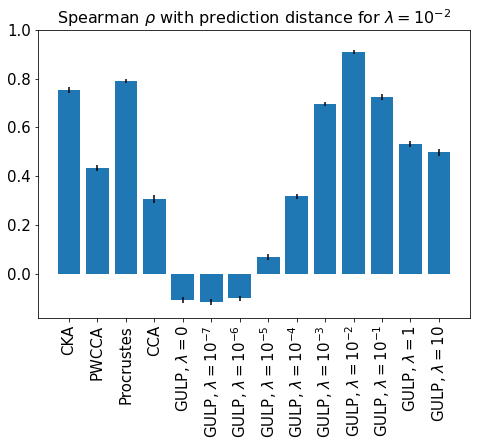

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


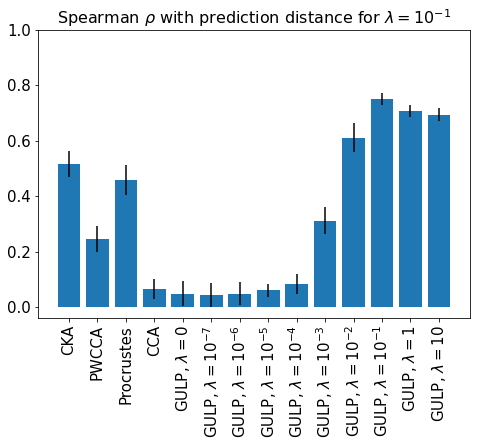

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [ ]:
# lmbda_vals = [0.001, 0.01, 0.1, 1]
# lmbda_names = ["10^{-3}", "10^{-2}", "10^{-1}", "1"]
lmbda_vals = [0.01, 0.1, 1]
lmbda_names = ["10^{-2}", "10^{-1}", "1"]
for lmbda_ind, lmbda in enumerate(lmbda_vals):
    labels, collected_correlations = get_collected_correlations(lmbda, numtrials=10,numtrainsamples=5000)
    
    std_devs = []
    means = []
    for i in range(len(collected_correlations[0])):
        cvs = [collected_correlations[j][i] for j in range(len(collected_correlations))]
        std_devs.append(scipy.stats.sem(cvs))
        means.append(np.mean(cvs))
    std_devs = np.array(std_devs)
    means = np.array(means)
    
    subset_labels = ['lin_cka_dist', 'pwcca_dist_e2e', 'procrustes', 'mean_sq_cca_e2e', 'predictor_dist_0.0', 'predictor_dist_1e-07', 'predictor_dist_1e-06', 'predictor_dist_1e-05', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0']
    subset_label_names = [label_names_dict[x] for x in subset_labels]
    subset_indices = []
    for i in range(len(subset_labels)):
        subset_indices.append(labels.index(subset_labels[i]))
        
    lbels = labels
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(range(len(subset_labels)),means[subset_indices], yerr = std_devs[subset_indices])
    plt.xticks(range(len(subset_labels)), labels=subset_label_names, rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(top=1)
    plt.title(f'Spearman $\\rho$ with prediction distance for $\\lambda = {lmbda_names[lmbda_ind]}$', fontsize=16)
    plt.savefig('../paper_figures/generalization_lambda' + str(lmbda) + '.pdf', bbox_inches='tight')
    plt.show()